# What Features Affect a Borrower's Loan Rate and Prosper Rating
## by Alf Maglalang

## Investigation Overview

> The goal of the investigation is to examine through visualizations which features have relationships with **Prosper Rating** and `BorrowerRate`. I am conflating **Prosper Rating** to mean the features `CreditGrade` and `ProsperRating (numeric)` (renamed `ProsperRating` which are mutually exclusive with `CreditGrade` before mid 2009 and `ProsperRating (numeric)` after mid-2009. I will proceed in steps below.
> 1. I will compare `ProsperScore` and `ProsperRating` to correct "errors" in `ProsperScore`. I will impute correct ones based on `ProsperRating`.
> 2. I will combine `ProsperRating` and `CreditGrade` in a new column `ProsperRatingGrade` and see its effects.
> 3. I will see how `BorrowerRate` compare to the other features.
> 3. I will see how `ProsperRatingGrade` compare to the other features.

## Dataset Overview

> This loan data is from a lending company called **Prosper**. It was last updated 3/11/2014. It has 113937 records with 81 features, namely

> `ListingKey`, `ListingNumber`, `ListingCreationDate`, `CreditGrade`, `Term`, `LoanStatus`, `ClosedDate`, `BorrowerAPR`, `BorrowerRate`, `LenderYield`, `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn`, `ProsperRating (numeric)`, `ProsperRating (Alpha)`, `ProsperScore`, `ListingCategory (numeric)`, `BorrowerState`, `Occupation`, `EmploymentStatus`, `EmploymentStatusDuration`, `IsBorrowerHomeowner`, `CurrentlyInGroup`, `GroupKey`, `DateCreditPulled`, `CreditScoreRangeLower`, `CreditScoreRangeUpper`, `FirstRecordedCreditLine`, `CurrentCreditLines`, `OpenCreditLines`, `TotalCreditLinespast7years`, `OpenRevolvingAccounts`, `OpenRevolvingMonthlyPayment`, `InquiriesLast6Months`, `TotalInquiries`, `CurrentDelinquencies`, `AmountDelinquent`, `DelinquenciesLast7Years`, `PublicRecordsLast10Years`, `PublicRecordsLast12Months`, `RevolvingCreditBalance`, `BankcardUtilization`, `AvailableBankcardCredit`, `TotalTrades`, `TradesNeverDelinquent (percentage)`, `TradesOpenedLast6Months`, `DebtToIncomeRatio`, `IncomeRange`, `IncomeVerifiable`, `StatedMonthlyIncome`, `LoanKey`, `TotalProsperLoans`, `TotalProsperPaymentsBilled`, `OnTimeProsperPayments`, `ProsperPaymentsLessThanOneMonthLate`, `ProsperPaymentsOneMonthPlusLate`, `ProsperPrincipalBorrowed`, `ProsperPrincipalOutstanding`, `ScorexChangeAtTimeOfListing`, `LoanCurrentDaysDelinquent`, `LoanFirstDefaultedCycleNumber`, `LoanMonthsSinceOrigination`, `LoanNumber`, `LoanOriginalAmount`, `LoanOriginationDate`, `LoanOriginationQuarter`, `MemberKey`, `MonthlyLoanPayment`, `LP_CustomerPayments`, `LP_CustomerPrincipalPayments`, `LP_InterestandFees`, `LP_ServiceFees`, `LP_CollectionFees`, `LP_GrossPrincipalLoss`, `LP_NetPrincipalLoss`, `LP_NonPrincipalRecoverypayments`, `PercentFunded`, `Recommendations`, `InvestmentFromFriendsCount`, `InvestmentFromFriendsAmount`, `Investors`

> Please click on the following link to see the definitions of the data's features. [Prosper Data Dictionary to Explain Dataset's Variables](https://www.google.com/url?q=https://docs.google.com/spreadsheet/ccc?key%3D0AllIqIyvWZdadDd5NTlqZ1pBMHlsUjdrOTZHaVBuSlE%26usp%3Dsharing&sa=D&ust=1554486256024000)

> For my analysis, I will look at these features:
> `ListingKey`, `EmploymentStatusDuration`, `EmploymentStatus`, `LoanOriginalAmount`, `CreditGrade`, `ProsperRating (numeric)`, `ProsperScore`, `BorrowerRate`, `CreditScoreRangeUpper`, `CurrentDelinquencies`, `IsBorrowerHomeowner`, `CurrentCreditLines`, `AvailableBankcardCredit`

> I created 3 new features and renamed two.

> - `ProsperRating` -- renaming of `ProsperRating (numeric)` 
> - `CreditScore` -- renaming of `CreditScoreRangeUpper`
> - `ProsperScoreRange` -- a column containing a string of "incorrect" `ProsperScore`s of duplicated `ListingKey` IDs
> - `ProsperRatingGrade` -- a column combining `CreditGrade` and `ProsperRating`
> - `IsPost2009` -- a column that is a form of boolean mask differentiating if a `ProsperRatingGrade` is originally from `CreditGrade` or from `ProsperRating`.

In [80]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [81]:
# load in the dataset into a pandas dataframe
# pld will be short for prosperLoanData
pld = pd.read_csv('prosperLoanData.csv')

In [82]:
print(select_features)

['ListingKey', 'EmploymentStatusDuration', 'EmploymentStatus', 'LoanOriginalAmount', 'CreditGrade', 'ProsperRating', 'ProsperScore', 'ProsperScoreRange', 'ProsperRatingGrade', 'IsPost2009', 'BorrowerRate', 'CreditScore', 'CurrentDelinquencies', 'IsBorrowerHomeowner', 'CurrentCreditLines', 'AvailableBankcardCredit']


## Remove Duplicate ListingKey IDs (while preserving ProsperScore)

In [83]:
# dup_listing_idx contains the keys that have duplicates:
dup_idx = pld[pld.ListingKey.duplicated()]['ListingKey']
dup_listing_idx = set(dup_idx.tolist())

In [166]:
tpld = pld.copy()

In [167]:
# trim spaces to make sure it is not spaces that make a difference
tpld = tpld.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# create a dataframe with just ListingKey and ProsperScore
lk_ps_df = tpld[tpld.ListingKey.isin(dup_listing_idx)][['ListingKey', 'ProsperScore']]
lk_ps_df = lk_ps_df.sort_values(by=['ListingKey', 'ProsperScore'])

# create a new column ProsperScoreRange and set index to ListingKey
lk_ps_df['ProsperScoreRange'] = None
lk_ps_df = lk_ps_df.set_index(['ListingKey'])

# create a dictionary with key as ListingKey and the ProsperScore range as value
psr_dict = {}
for lk in dup_listing_idx:
    psr_dict[lk] = lk_ps_df.loc[lk]['ProsperScore'].tolist()

# place all the new range value from the dictionary into dataframe column lk_ps_df['ProsperScoreRange']
for k, v in psr_dict.items():
    vstr = [str(i) for i in v] # convert the list into strings
    yy = ",".join(vstr)
    lk_ps_df.loc[k, 'ProsperScoreRange'] = yy

# reset the index then drop the column ProsperScore from lk_ps_df
lk_ps_df.reset_index(inplace=True)
lk_ps_df = lk_ps_df.drop(['ProsperScore'], axis=1)

# now remove all the duplicates on ListingKey
lk_ps_df.drop_duplicates(subset=['ListingKey'], inplace=True, keep='first')

temp_cols = ['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade', 'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey', 'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 'LoanKey', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing', 'LoanCurrentDaysDelinquent', 'LoanFirstDefaultedCycleNumber', 'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationDate', 'LoanOriginationQuarter', 'MemberKey', 'MonthlyLoanPayment', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations', 'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors']

# drop all the duplicates in tpld based on temp_cols subset (i.e., without ProsperScore)
tpld.drop_duplicates(subset=temp_cols, inplace=True, keep='first')

# merge the two df tpld and lk_ps_df on ListingKey
tpld = pd.merge(tpld, lk_ps_df, on=['ListingKey'], how='left')

## Rename some columns

In [168]:
# rename ProsperRating (numeric) and CreditScoreRangeUpper
tpld = tpld.rename(columns={'ProsperRating (numeric)': 'ProsperRating', 'CreditScoreRangeUpper': 'CreditScore'})

## Convert CreditGrade to number rating

In [169]:
# pr_dict is based on the prosper rating definitions provided by Prosper
pr_dict = {'NC': 0, 'HR': 1, 'E': 2, 'D': 3, 'C': 4, 'B': 5, 'A': 6, 'AA': 7}
tpld.CreditGrade.replace(pr_dict, inplace=True)

## Create new column merging CreditGrade and ProsperRating

In [170]:
# create new column based on ProsperRating then merge CreditGrade into new column
tpld['ProsperRatingGrade'] = tpld['ProsperRating']
tpld.ProsperRatingGrade.update(tpld['CreditGrade'])
tpld.ProsperRatingGrade.isnull().sum()

131

## Create a mask column to differentiate pre-2009 and post-2009 ratings

### Please note that this is to facilitate plot drawing

In [171]:
# creating mask columns for ProsperRating and CreditGrade
tpld['IsPR'] = np.where(tpld.ProsperRating.notnull(), 'yes', None) # column IsPR
tpld['IsCG'] = np.where(tpld.CreditGrade.notnull(), 'maybe', None) # column 

# create column post2009 with copy of IsPR first, then update to include IsCG
tpld['IsPost2009'] = tpld['IsPR']
tpld.IsPost2009.update(tpld['IsCG'])

# replace all the 2 (the CreditGrade content) to 0
tpld.IsPost2009.replace('maybe', 'no', inplace=True)

In [172]:
#tpld[['IsPR', 'ProsperRating', 'IsCG', 'CreditGrade', 'IsPost2009']].sample(1300).head(20)

,IsPR,ProsperRating,IsCG,CreditGrade,IsPost2009
84074,None,NaN,maybe,3.0,no
111405,yes,3.0,None,NaN,yes
33769,yes,1.0,None,NaN,yes
102644,None,NaN,maybe,7.0,no
81530,yes,7.0,None,NaN,yes
25596,yes,6.0,None,NaN,yes
36408,yes,3.0,None,NaN,yes
87352,None,NaN,maybe,7.0,no
42458,None,NaN,maybe,1.0,no
7613,yes,3.0,None,NaN,yes


In [173]:
# clean up
tpld = tpld.drop(['IsPR', 'IsCG'], axis=1)
len(tpld.columns)

84

## Correct the errors in ProsperScore

In [176]:
# groupby ProsperRating and get the average of the other numeric fields per ProsperRating group
avgpr = tpld.groupby('ProsperRating').mean()

avgpr = avgpr.reset_index() # necessary to use ProsperRating again as a column
# create a dictionary ProsperRating as key and mean ProsperScore as value
p_score = dict(zip(avgpr.ProsperRating.apply(int), avgpr.ProsperScore.apply(np.ceil)))
p_score

In [177]:
# this is a little computationally expensive. There has to be a declarative way to do this
for idx in dup_listing_idx:
    pr = int(tpld[tpld.ListingKey.eq(idx)]['ProsperRating']) # get the ProsperRating to use for dict lookup
    tpld.loc[tpld.ListingKey.eq(idx), 'ProsperScore'] = p_score.get(pr)

In [178]:
peek_df = tpld[tpld.ListingKey.isin(dup_listing_idx)]
peek_df[['ProsperRating', 'ProsperScore', 'ProsperScoreRange']].head()

,ProsperRating,ProsperScore,ProsperScoreRange
8,7.0,10.0,"9.0,11.0"
28,6.0,9.0,"5.0,6.0"
175,2.0,4.0,"2.0,3.0"
312,5.0,7.0,"2.0,3.0"
348,5.0,7.0,"2.0,5.0"
441,4.0,6.0,"3.0,4.0"
443,4.0,6.0,"4.0,7.0"
454,5.0,7.0,"6.0,9.0"
460,4.0,6.0,"6.0,8.0"
639,6.0,9.0,"8.0,10.0"


## Extract the investigative features

In [179]:
select_features = ['ListingKey', 'EmploymentStatusDuration', 'EmploymentStatus', 'LoanOriginalAmount', 'CreditGrade', 'ProsperRating', 'ProsperScore', 'ProsperScoreRange', 'ProsperRatingGrade', 'IsPost2009', 'BorrowerRate', 'CreditScore', 'CurrentDelinquencies', 'IsBorrowerHomeowner', 'CurrentCreditLines', 'AvailableBankcardCredit']
df = tpld[select_features]

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113066 entries, 0 to 113065
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ListingKey                113066 non-null  object 
 1   EmploymentStatusDuration  105441 non-null  float64
 2   EmploymentStatus          110811 non-null  object 
 3   LoanOriginalAmount        113066 non-null  int64  
 4   CreditGrade               28953 non-null   float64
 5   ProsperRating             83982 non-null   float64
 6   ProsperScore              83982 non-null   float64
 7   ProsperScoreRange         827 non-null     object 
 8   ProsperRatingGrade        112935 non-null  float64
 9   IsPost2009                112935 non-null  object 
 10  BorrowerRate              113066 non-null  float64
 11  CreditScore               112475 non-null  float64
 12  CurrentDelinquencies      112369 non-null  float64
 13  IsBorrowerHomeowner       113066 non-null  b

In [181]:
df.shape

(113066, 16)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## What is ProsperScore to ProsperRating

> The journey began with the discovery that there were duplicate records that only differed in the `ProsperScore` column. To correct these "errors", I set to determine and use the relationship between `ProsperRating` and `ProsperScore` since `ProsperRating` is the most correlative to `ProsperScore`.
> The visual below illustrate that `ProsperRating` is a reasonable measure to determine "correct" `ProsperScore`.
> I ultimately used the average ProsperScore corresponding to ProsperRating.

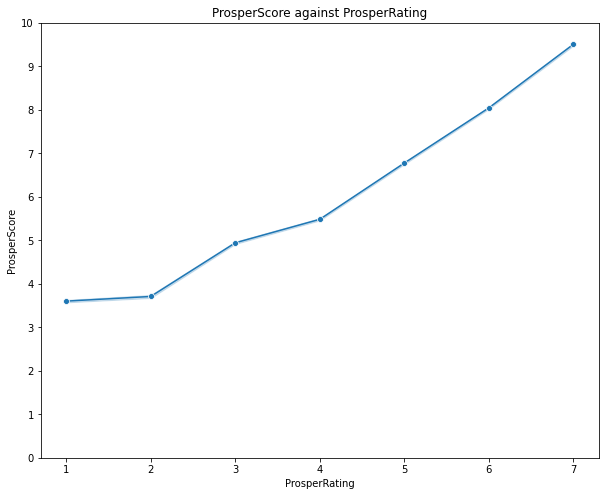

In [182]:
fig, ax = plt.subplots(figsize=(10,8))
sb.lineplot(data=df, x='ProsperRating', y='ProsperScore', marker='o')
ax.set_yticks(np.arange(11)) # ProsperScore is a number between 1 and 10 inclusive
plt.title('ProsperScore against ProsperRating');

## How BorrowerRate compare against old `CreditGrade` and the new `ProsperRating`

> Should I have combined CreditGrade and ProsperRating into one column.

> The plot below shows that the correspondence of `CreditGrade` and `ProsperRating` to BorrowerRate is comparable

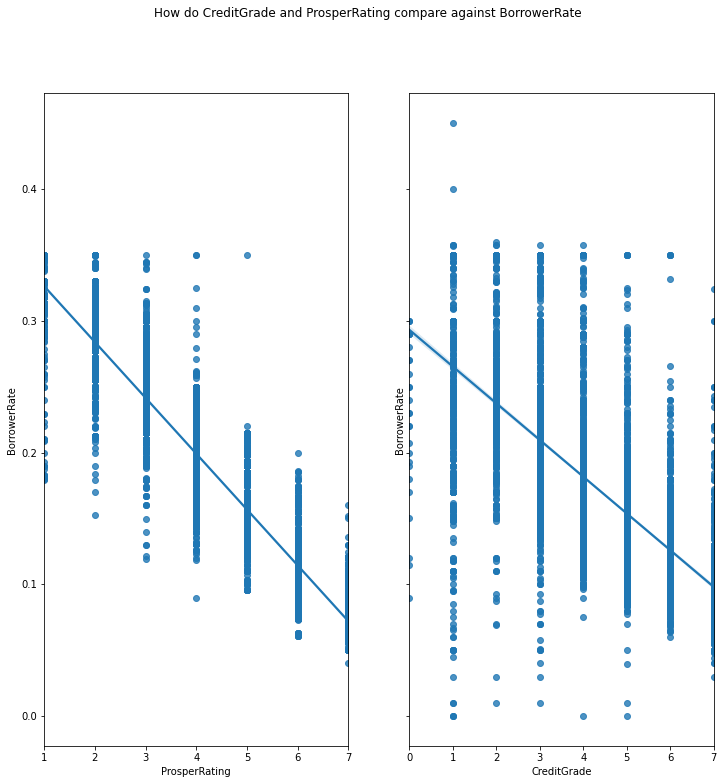

In [218]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,12))
sb.regplot(x='ProsperRating', y='BorrowerRate', ax=ax1, data=df.sample(frac=.25))
sb.regplot(x='CreditGrade', y='BorrowerRate', ax=ax2, data=df.sample(frac=.25))
#sb.regplot(x='ProsperRatingGrade', y='BorrowerRate', ax=ax3, data=df.sample(frac=.25))
#ax2.set_xlim(left=1)
fig.suptitle('How do CreditGrade and ProsperRating compare against BorrowerRate');

## BorrowerRate against Prosper Rating, pre-2009 and post-2009

> The BorrowerRate seems to correspond well with ProsperRating and CreditGrade proportionaly. But below shows a supplementary tale. **CreditGrade** (pre-2009) had bigger ranges of BorrowerRate while **ProsperRating** had shorter more determinant ranges.

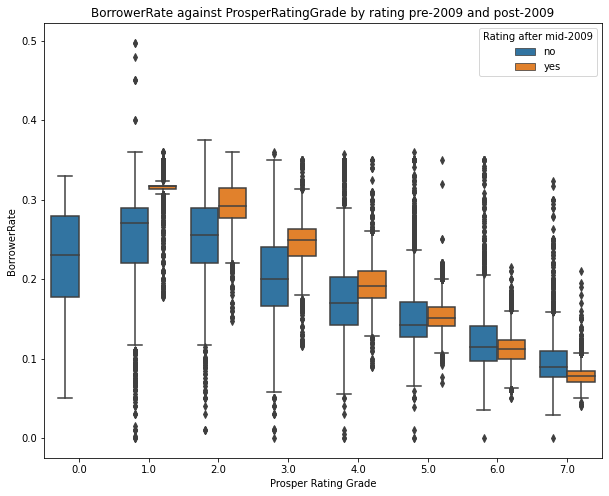

In [184]:
plt.figure(figsize=(10,8))
sb.boxplot(x='ProsperRatingGrade', y='BorrowerRate', hue='IsPost2009', data=df)
plt.legend(title='Rating after mid-2009')
plt.xlabel('Prosper Rating Grade')
plt.title('Borrower Rate against combined Prosper Ratings by rating pre-2009 and post-2009');

## Do **CreditGrade** and **ProsperRating** differ somewhere else

> Before mid-2009, **CreditGrade** was very closely tied to CreditScore as it is evident in their narrow ranges and non-overlapping graduated ascent, also not that there were no outliers other than in rating 1. After mid-2009, the ranges of credit scores were slightly more diversed with a lot overlap. This tells me that **ProsperRating** was not as tied to credit scores as **CreditGrade** was.

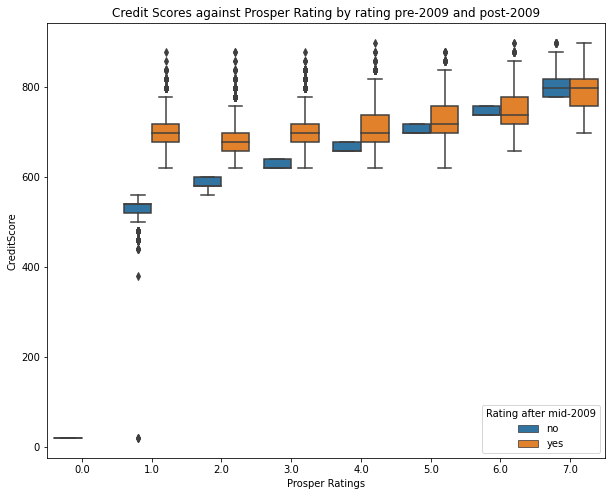

In [187]:
plt.figure(figsize=(10,8))
sb.boxplot(x='ProsperRatingGrade', y='CreditScore', hue='IsPost2009', data=df)
plt.legend(title='Rating after mid-2009')
plt.xlabel('Prosper Ratings')
plt.title('Credit Scores against Prosper Rating by rating pre-2009 and post-2009');

## other correspondences

> It is interesting to see that regression lines of `BorrowerRate` vs the regression lines of `ProsperRatingGrade` (against other features) **mirro** each other in slope.

<Figure size 864x864 with 0 Axes>

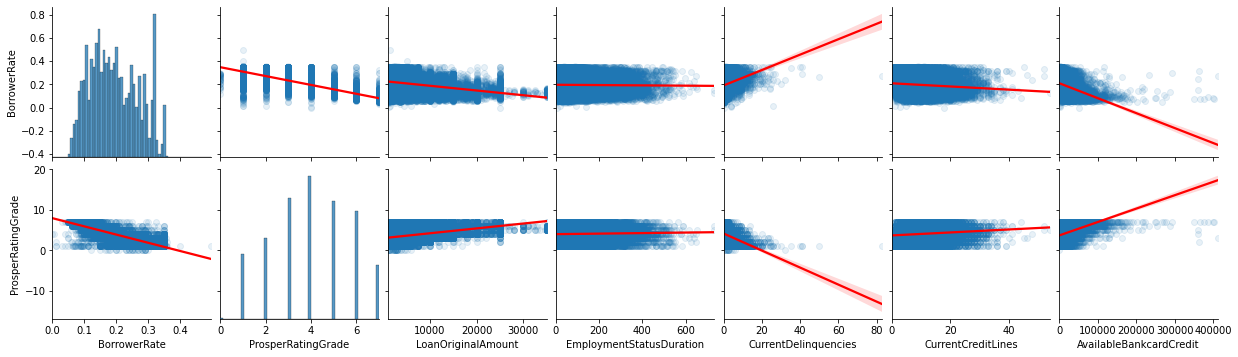

In [220]:
x_vars = ['BorrowerRate', 'ProsperRatingGrade', 'LoanOriginalAmount', 'EmploymentStatusDuration', 'CurrentDelinquencies', 'CurrentCreditLines', 'AvailableBankcardCredit']
plt.figure(figsize=(12,12))
sb.pairplot(data=df.sample(frac=.25), y_vars=['BorrowerRate', 'ProsperRatingGrade'], x_vars=x_vars, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

## other correspondences

> Before mid-2009, **CreditGrade** was very closely tied to CreditScore as it is evident in their narrow ranges and non-overlapping graduated ascent, also not that there were no outliers other than in rating 1. After mid-2009, the ranges of credit scores were slightly more diversed with a lot overlap. This tells me that **ProsperRating** was not as tied to credit scores as **CreditGrade** was.

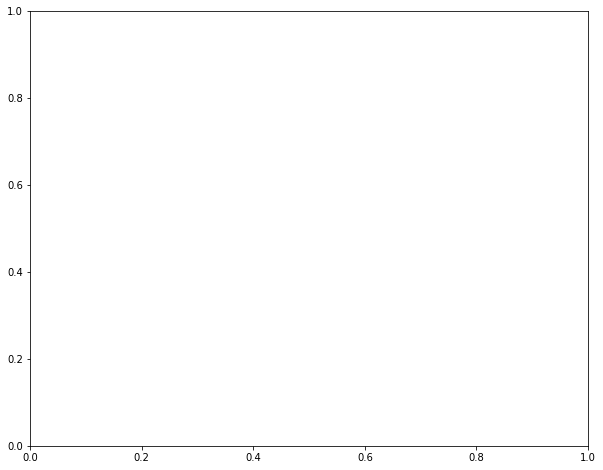

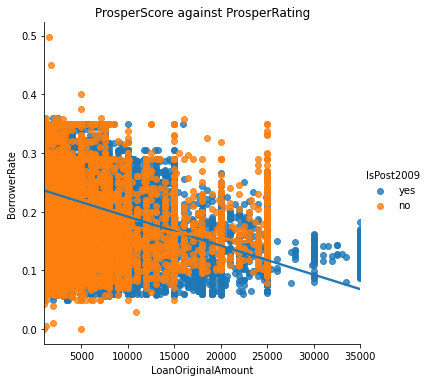

In [198]:
#fig, ax = plt.subplots(figsize=(10,8))
plt.figure(figsize=(10,8))
sb.lmplot(data=df.sample(frac=.25), x='LoanOriginalAmount', y='BorrowerRate')
#ax.set_yticks(np.arange(11))
plt.title('ProsperScore against ProsperRating');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!